<a href="https://colab.research.google.com/github/sayakpaul/mai21-learned-smartphone-isp/blob/master/Learned_Smartphone_ISP_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains the baseline model on the training dataset for 10000 iterations. It takes ~3 hours on a Tesla T4 GPU. The notebook also shows how to convert the trained model checkpoints to a frozen inference graph, use it for inference, convert it to TensorFlow Lite, and use it for inference. 

## Important Links 
* [MAI Workshop CVPR 2021](https://ai-benchmark.com/workshops/mai/2021/)
* [Learned Smartphone ISP Challenge](https://competitions.codalab.org/competitions/28054)

## Initial Setup

In [ ]:
%tensorflow_version 1.x
!nvidia-smi

TensorFlow 1.x selected.
Fri Jan 29 07:45:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                               

In [ ]:
# Get the training data
!wget https://data.vision.ee.ethz.ch/timofter/MAI21LearnedISP/MAI2021_LearnedISP_train.zip
!unzip -qq MAI2021_LearnedISP_train.zip

--2021-01-29 07:45:44--  https://data.vision.ee.ethz.ch/timofter/MAI21LearnedISP/MAI2021_LearnedISP_train.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4018305950 (3.7G) [application/zip]
Saving to: ‘MAI2021_LearnedISP_train.zip’

MAI2021_LearnedISP_ 100%[===================>]   3.74G  19.9MB/s    in 3m 14s  

2021-01-29 07:48:59 (19.8 MB/s) - ‘MAI2021_LearnedISP_train.zip’ saved [4018305950/4018305950]



In [ ]:
# We want to learn a mapping between the RAW and RGB images to bypass the
# ISP step 
!ls -lh /content/mediatek_raw | head -10
!ls -lh /content/fujifilm | head -10

total 1.8G
-rw-r--r-- 1 root root  81K Dec 31 17:17 0.png
-rw-r--r-- 1 root root  93K Jan  1 07:36 10000.png
-rw-r--r-- 1 root root  92K Jan  1 07:36 10001.png
-rw-r--r-- 1 root root  90K Jan  1 07:36 10002.png
-rw-r--r-- 1 root root  91K Jan  1 07:36 10003.png
-rw-r--r-- 1 root root  82K Jan  1 07:36 10004.png
-rw-r--r-- 1 root root  87K Jan  1 07:36 10005.png
-rw-r--r-- 1 root root  85K Jan  1 07:36 10006.png
-rw-r--r-- 1 root root  84K Jan  1 07:36 10007.png
total 2.2G
-rw-r--r-- 1 root root 136K Dec 31 17:17 0.png
-rw-r--r-- 1 root root  42K Jan  1 07:36 10000.png
-rw-r--r-- 1 root root  42K Jan  1 07:36 10001.png
-rw-r--r-- 1 root root  41K Jan  1 07:36 10002.png
-rw-r--r-- 1 root root  43K Jan  1 07:36 10003.png
-rw-r--r-- 1 root root  47K Jan  1 07:36 10004.png
-rw-r--r-- 1 root root  67K Jan  1 07:36 10005.png
-rw-r--r-- 1 root root  71K Jan  1 07:36 10006.png
-rw-r--r-- 1 root root  70K Jan  1 07:36 10007.png


In [4]:
# Imports
from tqdm.notebook import tqdm
from imutils import paths
import shutil
import os

import random
random.seed(42)

## Data Splitting

In [5]:
rgb_images = sorted(list(paths.list_images("/content/fujifilm")))
raw_images = sorted(list(paths.list_images("/content/mediatek_raw")))
rgb_images[:5], raw_images[:5]

(['/content/fujifilm/0.png',
  '/content/fujifilm/1.png',
  '/content/fujifilm/10.png',
  '/content/fujifilm/100.png',
  '/content/fujifilm/1000.png'],
 ['/content/mediatek_raw/0.png',
  '/content/mediatek_raw/1.png',
  '/content/mediatek_raw/10.png',
  '/content/mediatek_raw/100.png',
  '/content/mediatek_raw/1000.png'])

**Note** that RAW images are the inputs and RGB images are the outputs. 

In [6]:
len(rgb_images), len(raw_images)

(24161, 24161)

In [7]:
i = int(len(rgb_images) * 0.9)

train_rgb_paths = rgb_images[:i]
train_raw_paths = raw_images[:i]
valid_rgb_paths = rgb_images[i:]
valid_raw_paths = raw_images[i:]

print(len(train_rgb_paths), len(train_raw_paths), len(valid_rgb_paths), len(valid_raw_paths))

21744 21744 2417 2417


In [8]:
def move_images(image_paths, target_directory):
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)
    for path in tqdm(image_paths):
        if os.path.isfile(path):
            filename = path.split("/")[-1]
            target_path = os.path.join(target_directory, filename)
            shutil.copy2(path, target_path)
    total_images = list(paths.list_images(target_directory))
    print(f"Copied over {len(total_images)} images")

In [9]:
move_images(train_rgb_paths, os.path.join("train", "fujifilm"))
move_images(train_raw_paths, os.path.join("train", "mediatek_raw"))


Copied over 21744 images



Copied over 21744 images


In [10]:
move_images(valid_rgb_paths, os.path.join("val", "fujifilm"))
move_images(valid_raw_paths, os.path.join("val", "mediatek_raw"))


Copied over 2417 images



Copied over 2417 images


Now that our data splits are ready let's set up the environment for starting model training. 

## Model Training Setup

In [11]:
!git clone https://github.com/MediaTek-NeuroPilot/mai21-learned-smartphone-isp
%cd mai21-learned-smartphone-isp

Cloning into 'mai21-learned-smartphone-isp'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 43 (delta 11), reused 41 (delta 9), pack-reused 0
Unpacking objects: 100% (43/43), done.
/content/mai21-learned-smartphone-isp


In [12]:
!mv /content/train raw_images
!mv /content/val raw_images

In [ ]:
# Download VGG19 weights pre-trained on ImageNet1K
# We will use this to extract meaningful features
!gdown --id 0BwOLOmqkYj-jMGRwaUR2UjhSNDQ -O imagenet-vgg-verydeep-19.mat
!mv imagenet-vgg-verydeep-19.mat vgg_pretrained

Downloading...
From: https://drive.google.com/uc?id=0BwOLOmqkYj-jMGRwaUR2UjhSNDQ
To: /content/mai21-learned-smartphone-isp/imagenet-vgg-verydeep-19.mat
576MB [00:07, 81.5MB/s]


Please replace the existing `load_dataset.py` script with [this one](https://). We are now ready to start model training.

## Model Training

<font color=red>It takes ~3 hours on a Tesla T4.</font>

If you run out of memory while running this try reducing the batch size and then restart the training. 

In [ ]:
!python train_model.py \
    arch=punet num_maps_base=16 \
    patch_w=256 patch_h=256 batch_size=32 \
    train_size=2000 eval_step=1000 num_train_iters=10000

The following parameters will be applied for training:
Model architecture: punet
Restore Iteration: -1
Batch size: 32
Training size: 2000
Learning rate: 5e-05
Training iterations: 10000
Evaluation step: 1000
Path to the dataset: raw_images/
Path to Raw-to-RGB model network: models/
Path to result images: results/
Path to VGG-19 network: vgg_pretrained/imagenet-vgg-verydeep-19.mat
Path to RGB data from DSLR: fujifilm/
Path to Raw data from phone: mediatek_raw/
2021-01-29 08:34:58.473081: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-29 08:34:58.507315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-29 08:34:58.507861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.

## (Optional) Move the checkpoints to your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/drive/MyDrive/MAI_CVPR
!cp -r models /content/drive/MyDrive/MAI_CVPR

## Test Data Preparation

Here, we take 5 images from the validation set and copy them over to a directory that our test script expects. 

In [16]:
!mkdir /content/mai21-learned-smartphone-isp/raw_images/test
!cd /content/mai21-learned-smartphone-isp/raw_images/val/mediatek_raw && \
    find . -maxdepth 1 -type f |head -5|xargs cp -t /content/mai21-learned-smartphone-isp/raw_images/test

In [17]:
!mkdir raw_images/test/mediatek_raw
!cp -r raw_images/test/*.png raw_images/test/mediatek_raw
!rm -rf raw_images/test/*.png

## Model Inference

Please replace `test_model.py` with [this one](https://gist.github.com/sayakpaul/b94ab8c6664ae01c607fc229a1eb1129#file-test_model-py). 

In [ ]:
!python test_model.py \
    dataset_dir=raw_images test_dir=mediatek_raw orig=False \
    img_h=256 img_w=256 use_gpu=True save=True test_image=True

The following parameters will be applied for testing:
Model architecture: punet
Restore Iteration: 10000
Path to the dataset: raw_images
Path to Raw-to-RGB model network: models/
Path to result images: results/
Path to testing data: mediatek_raw
2021-01-29 12:13:14.029100: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-29 12:13:14.062438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-29 12:13:14.062985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla T4 major: 7 minor: 5 memoryClockRate(GHz): 1.59
pciBusID: 0000:00:04.0
2021-01-29 12:13:14.063269: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-01-29 12:13:14.065220: I tensorflow/strea

**Optional**: Go back and investigate the outputs of the `results` directory. 

## Conversion to TensorFlow Lite (TFLite)

Please restart the Colab runtime and then proceed as we will be using TensorFlow 2 from here. 

In [1]:
%tensorflow_version 2.x

In [24]:
# Imports
import tensorflow as tf
print(tf.__version__)

from load_dataset import extract_bayer_channels
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import imageio

2.4.1


## Convert frozen inference graph to TFLite 

In [20]:
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='models/punet_iteration_10000.pb', 
    input_arrays=['Placeholder'],
    output_arrays=['output_l0'],
    input_shapes={'Placeholder': [1, 128, 128, 4]}
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
print('TFLite Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0) )
open('punet_model_dr.tflite', 'wb').write(tflite_model)

TFLite Model size is 6.674118 MBs.


6998320

## Inference utility

In [23]:
 # Reference: 
 # https://github.com/MediaTek-NeuroPilot/mai21-learned-smartphone-isp/blob/master/test_model.py#L66-#L70
 def preprocess_func(image_path):
    I = np.asarray(imageio.imread(image_path))
    I = extract_bayer_channels(I)
    I = I[0:256//2, 0:256//2, :]
    I = np.reshape(I, [1, I.shape[0], I.shape[1], 4])
    return I

In [26]:
test_images = list(paths.list_images("/content/mai21-learned-smartphone-isp/raw_images/test"))
test_images

['/content/mai21-learned-smartphone-isp/raw_images/test/mediatek_raw/7843.png',
 '/content/mai21-learned-smartphone-isp/raw_images/test/mediatek_raw/7996.png',
 '/content/mai21-learned-smartphone-isp/raw_images/test/mediatek_raw/889.png',
 '/content/mai21-learned-smartphone-isp/raw_images/test/mediatek_raw/9847.png',
 '/content/mai21-learned-smartphone-isp/raw_images/test/mediatek_raw/8724.png']

## Run TFLite model for Inference

In [32]:
def run_tflite_model(image):
    interpreter = tf.lite.Interpreter(model_path="punet_model_dr.tflite")
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()

    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    enhanced_image = interpreter.tensor(interpreter.get_output_details()[0]['index'])()
    enhanced_image = np.clip(enhanced_image, 0., 1.)
    enhanced_image = np.reshape(enhanced_image, 
               [int(image.shape[1] * 2.0), int(image.shape[2] * 2.0), 3])
    
    return enhanced_image

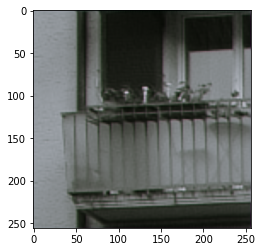

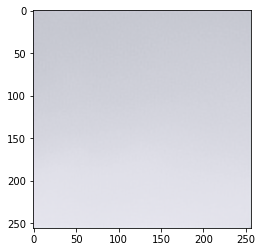

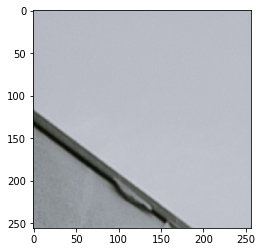

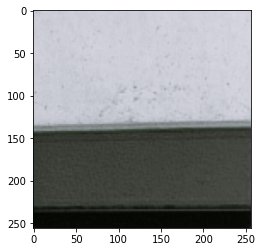

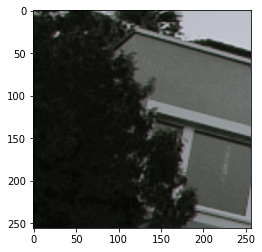

In [33]:
for test_image in test_images:
    image_preprocessed = preprocess_func(test_image)
    enhanced_image = run_tflite_model(image_preprocessed)
    plt.imshow(enhanced_image)
    plt.show()